**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Inhomogeneous Source, and Dirichlet BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**21 Oct 2024**

---
## Table of Contents<a id="toc"></a>
* [Problem Conditions](#conds)
* [Setup](#setup)
* [Test Three](#test)
---

## [Problem Conditions](#toc)<a id="setup"></a>

Source bias is dependent on the position using Dirichlet Boundary conditions and the following parameters:

+ $k(x) = 87219 \left [ \frac{W}{mK} \right ]$
+ $f(x) = 206 151+129 400 \cdot x \; \left [ \frac{W}{m^{3}} \right ]$
+ $T(a) = 20$ [°C], and $T(b)= 40$ [°C]


## [Setup](#toc)<a id="test"></a>

In [1]:
'''Generate the target function f'''
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [2]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min=0
x_max=0.05

degree = 2  #Degree of the lagrange polinomials used
n_elem = 10 #Number of elements used

In [3]:
'''Domain partition'''
from pyfires import get_domain_partition

In [4]:
'''Parent mapping'''
from pyfires import get_parent_mapping

In [5]:
'''The basis functions'''
from pyfires import get_parent_basis_functions

In [6]:
'''Global basis functions'''
from pyfires import global_basis_function

In [7]:
'''All global basis functions'''
from pyfires import get_global_basis_functions

In [8]:
'''Pedagogical inner product'''
from pyfires import inner_product

## [Implementing Constrants](#toc)<a id="test"></a>

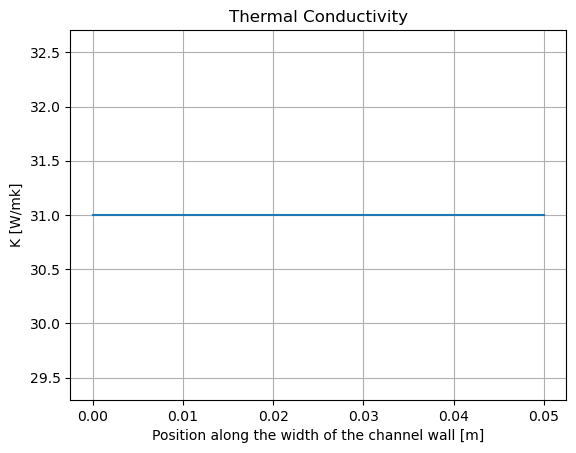

In [9]:
'''Parameters'''
'''Thermal conductivity'''
Cond_shape_pts = [(0,31),(0.05,31)]
#Cond_shape_pts = [(0,24.803),(0.05,25.777)]
Cond=np.array(Cond_shape_pts)
f_cond=interp1d(Cond[:,0],Cond[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200),f_cond(np.linspace(0,0.05,200)),label='Target Function')
plt.title ('Thermal Conductivity')
plt.xlabel('Position along the width of the channel wall [m]')
plt.ylabel ('K [W/mk]')
plt.grid()
plt.show()

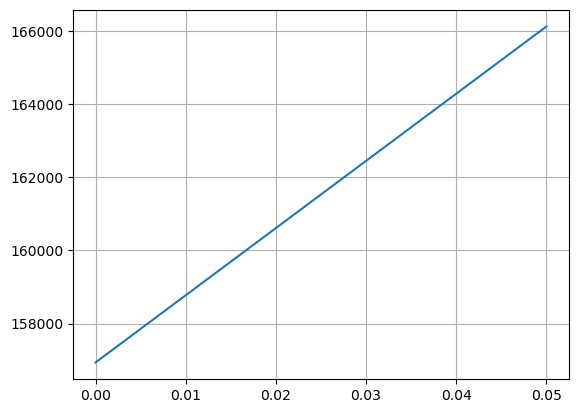

In [10]:
'''Source bias'''
Source_shape_pts = [(0,156940),(0.05,166117)]
source=np.array(Source_shape_pts)

f_sourcebias=interp1d(source[:,0],source[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200),f_sourcebias(np.linspace(0,0.05,200)),label='Target Function')
plt.grid()
plt.show()

In [11]:
'''FEM Solution'''
'''Domain partition'''
def get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='essential', bc_x_max='essential'):
    #assert degree == 1
    # Local node numbering on parent domain
    # --0--------------1---->
    #  -1      0      +1    zetta
    gnodes_x = np.linspace(x_min, x_max, n_elem*degree+1, dtype=np.float64)
    patches = list()
    local_to_global_node_id_map = list()
    for e in range(n_elem):
        gnode_id_1 = degree*e   #left
        gnode_id_2 = degree*e+1 #center
        gnode_id_3 = degree*e+2 #right
        x1 = gnodes_x[gnode_id_1]
        x2 = gnodes_x[gnode_id_2]
        x3 = gnodes_x[gnode_id_3]
        # Local node id:  0   1
        patches.append((x1, x2, x3))
        # Local node id:                        0           2             1
        local_to_global_node_id_map.append([gnode_id_1, gnode_id_2,  gnode_id_3])
    if bc_x_min == 'essential':
        local_to_global_node_id_map[0][0] = -1
    if bc_x_max == 'essential':
        local_to_global_node_id_map[-1][-1] = -1
    return (patches, gnodes_x, local_to_global_node_id_map)

domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

In [12]:
#Building of the A matrix
A_mtrx = np.zeros((len(phi_list), len(phi_list)), dtype=np.float64)
patches = domain_partition[0]
for i in range(len(phi_list)):
    for j in range(len(phi_list)):
        
        phi_i=phi_list[i]
        phi_j=phi_list[j]
        
        phi_prime_i=phi_prime_list[i]
        phi_prime_j=phi_prime_list[j]
        
        h_e=(x_max-x_min)/n_elem
        
        d_x_phi_prime_j = lambda x: f_cond(x) * ((2/h_e)*phi_prime_j(x))
        
        prima = lambda x: phi_prime_i(x)*(2/h_e)
        
        A_mtrx[i,j] = inner_product(prima, d_x_phi_prime_j, patches)

In [13]:
'''Solution'''
'''Compute optimal coefficient vector'''
c_star_vec = np.linalg.solve(A_mtrx, b_vec)

plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),u_star(np.linspace(x_min,x_max,2000)),label='Rayleigh-Ritz solution')
#plt.plot(np.linspace(x_min,x_max,2000),sol(np.linspace(x_min,x_max,2000)),label='Analytic solution')
plt.xlabel("Position along the width of the channel wall [m]")
plt.title('Solutions with Dirichlet BC, variable source')
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid()
plt.show()

print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min))
print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max))

#Plotting the flux
plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),-f_cond(np.linspace(x_min,x_max,2000))*u_star_prime((np.linspace(x_min,x_max,2000))),label='Rayleigh Ritz solution')
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("Heat flux [W/m2]")
plt.legend()
plt.grid()
plt.show()

'''Flux at boundary'''
print('q_na computed = ', -f_cond(x_min)*u_star_prime(x_min))
print('q_nb computed = ', -f_cond(x_max)*u_star_prime(x_max))
#print('q_nb given    = ', q_nb)
#print('flux error [%]= ',(-f_cond(x_max)*g_prime(x_max) - q_nb)/q_nb*100)

NameError: name 'b_vec' is not defined

In [ ]:
'''Build load vector'''
#The load vector
b_vec = np.zeros(len(phi_list), dtype=np.float64)
patches = domain_partition[0]

for i in range(len(phi_list)):
    phi_i=phi_list[i]
    phi_prime_i=phi_prime_list[i]
    
    b_vec[i] = inner_product(f_sourcebias, phi_i, patches)
    
    first_term = lambda x: f_lift_prime(x)*f_cond(x)
    phi_prima_i = lambda x: phi_prime_i(x)*(2/h_e)
    
    b_vec[i] -= inner_product(first_term, phi_prima_i, patches)